In [1]:
%%capture
from scipy.optimize import minimize 
%run EOMs.ipynb
%matplotlib inline

- Confirmed numerically the definitions of the separatrix, $k$, $k_{crit}$, and $H_{sep}$
- For this section, need to run Preamble, EOMs above, and Symbols & expressions below

# Symbols & expressions

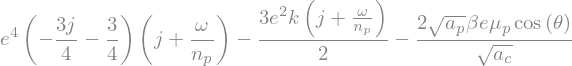

In [2]:
ac = symbols("a_c",positive=True)
H_simp_expr = (
    -Rational(3, 4) * (j + 1) * (j + om / np) * e**4
    - Rational(3, 2) * k * (j + om / np) * e**2
    - 2 * b * sqrt(ap / ac) * mup * e * cos(th)
)
H_simp_expr

In [3]:
H_simp_expr.free_symbols

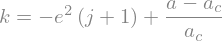

In [4]:
k_expr = (a-ac)/ac - (j+1)*e**2
Eq(k,k_expr)

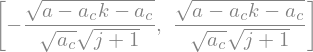

In [5]:
solve(Eq(k,k_expr),e)

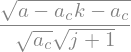

In [6]:
e_expr_a_k = solve(Eq(k,k_expr),e)[1]
e_expr_a_k

# Single capture run

## Integrate

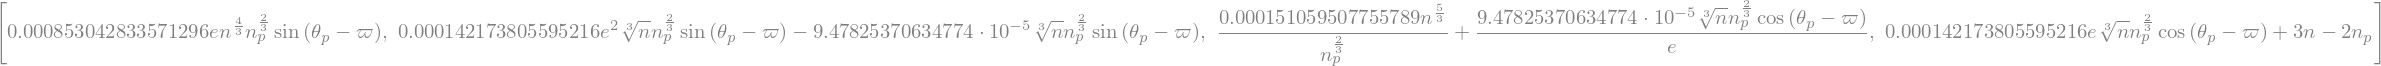

In [73]:
TMVAL = 2 * npy.pi * 1e6
convs = {}
convs = {ap: n ** Rational(2, 3) / np ** Rational(2, 3) * a, th: thp + omp * t - pom}
params = {}
params = {
    j: 2,
    mup: 5e-5,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    b1_3_2: 12.08476062046314,
    b2_3_2: 10.485706741948807,
    ep: 0.0
}

alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
params[omp] = 0
params[om] = params[omp] * alpha0val**3.5


funs = [
    iterfun.subs(convs).subs(params)
    for iterfun in [ndot, edot + edsec, pomdot + pomdsec, thpdot]
]
funs

In [74]:
xp = [n, e, pom, thp, np, t]

In [75]:
T_TURNOFF = 2.5e5
funcl = lambdify(xp, funs)
def func(t, x0):
    if t < T_TURNOFF: 
        npval = npy.exp(-t/TMVAL)
    else:
        npval = npy.exp(-T_TURNOFF/TMVAL)
    return funcl(*x0, npval, t)

In [76]:
teval = npy.linspace(0, 2 * npy.pi * 0.5e5, 10000)
sol = sp.integrate.solve_ivp(
    func,
    [teval[0], teval[-1]],
    [1/1.55, 0.001, 1, 2],
    t_eval=teval,
    rtol=1e-9,
    #atol=1e-9,
    method="DOP853",
)

In [77]:
a_vals = sol.y[0, :] ** (-2.0 / 3)
np_vals = npy.exp(-sol.t / TMVAL)
np_vals[npy.where(sol.t > T_TURNOFF)] = npy.exp(-T_TURNOFF / TMVAL)

ap_vals = np_vals ** (-2.0 / 3)
nc_vals = (params[om] + params[j] * np_vals) / (params[j] + 1)
ac_vals = nc_vals ** (-2.0 / 3)
e_vals = sol.y[1, :]
th_vals = (sol.y[3, :] + params[omp] * sol.t - sol.y[2, :]) % (2 * npy.pi)
k_vals = (a_vals - ac_vals) / ac_vals - (params[j] + 1) * e_vals**2
k_crit = -(
    (3 * (params[j] + 1) * ap_vals * params[b] ** 2 / (params[j] ** 2 * ac_vals))
    ** (1.0 / 3)
) * params[mup] ** (2.0 / 3)

H_vals = (
    -0.75 * (params[j] + 1) * (params[j] + params[om] / np_vals) * e_vals**4
    - 1.5 * k_vals * (params[j] + params[om] / np_vals) * e_vals**2
    - 2
    * params[b]
    * npy.sqrt(ap_vals / ac_vals)
    * params[mup]
    * e_vals
    * npy.cos(th_vals)
)

## Evolution plot

<Figure size 640x480 with 0 Axes>

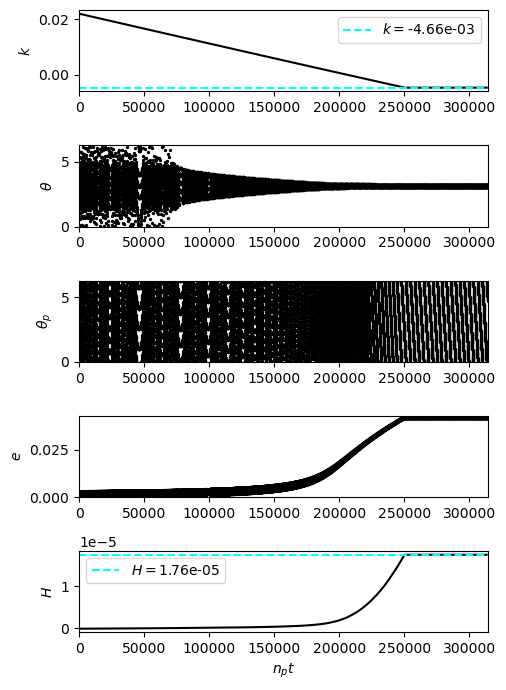

In [78]:
plt.clf()
plt.figure(figsize=(5, 7))

plt.subplot(5, 1, 1)
plt.ylabel(r"$k$")
plt.plot(sol.t, k_vals, c="k")
plt.axhline(y=k_vals[-1], c="cyan", ls="--", label=r"$k=$"+f"{k_vals[-1]:0.2e}")
plt.legend()

plt.subplot(5, 1, 2)
plt.ylabel(r"$\theta$")
plt.ylim(0, 2 * npy.pi)
plt.scatter(
    sol.t, (sol.y[3, :] + params[omp] * sol.t - sol.y[2, :]) % (2 * npy.pi), c="k", s=2
)

plt.subplot(5, 1, 3)
plt.ylabel(r"$\theta_p$")
plt.ylim(0, 2 * npy.pi)
plt.scatter(sol.t, sol.y[3, :] % (2 * npy.pi), c="k", s=2)

plt.subplot(5, 1, 4)
plt.ylabel(r"$e$")
plt.plot(sol.t, sol.y[1, :], c="k")
plt.ylim((0,npy.max(sol.y[1,:])))

plt.subplot(5, 1, 5)
plt.ylabel(r"$H$")
plt.plot(sol.t, H_vals, c="k")
plt.axhline(y=H_vals[-1], c="cyan", ls="--", label=r"$H=$"+f"{H_vals[-1]:0.2e}")
plt.legend()
plt.xlabel(r"$n_p t$")
plt.tight_layout()
for _ in plt.gcf().axes:
    _.set_xlim(sol.t[0], sol.t[-1])
save_to_clipboard()

## Hamiltonian Level Curve Plotting at a certain time index

In [79]:
snap_index = -1

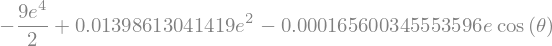

In [80]:
H_simp_expr_plugin = H_simp_expr.subs(
    {
        ac: ac_vals[snap_index],
        ap: ap_vals[snap_index],
        b: params[b],
        j: params[j],
        k: k_vals[snap_index],
        mup: params[mup],
        om: params[om],
    }
)
H_simp_expr_plugin

In [81]:
e_grid, th_grid = npy.meshgrid(npy.linspace(0.001,0.1,1000), npy.pi+npy.linspace(-npy.pi,npy.pi,1000))
H_func = lambdify([th,e],H_simp_expr_plugin)

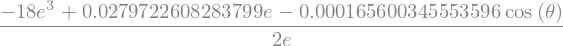

In [82]:
thdot = H_simp_expr_plugin.diff(e)/(2*e)
thdot

In [83]:
# Hamiltonian level curve on x-axis
#plt.clf()
#plt.plot(-e_grid[0,:],(lambda x: lambdify([th,e],thdot*e)(npy.pi,x))(e_grid[0,:]))
#plt.plot(e_grid[0,:],(lambda x: lambdify([th,e],thdot*e)(0,x))(e_grid[0,:]))
#plt.show()

In [84]:
root0 = brentq((lambda x: lambdify([th,e],thdot*e)(npy.pi,x)), 0.001,0.1)
root1 = brentq((lambda x: lambdify([th,e],thdot*e)(0,x)), 0.005,0.02)
root2 = brentq((lambda x: lambdify([th,e],thdot*e)(0,x)), 0.02,0.1)

In [85]:
root2

In [86]:
# Value of k
display(k_vals[snap_index])
# Value of H for separatrix at this k
H_sep_val = H_simp_expr_plugin.subs({th:0,e:root2})
display(H_sep_val)
# Current value of H
display(H_vals[snap_index])

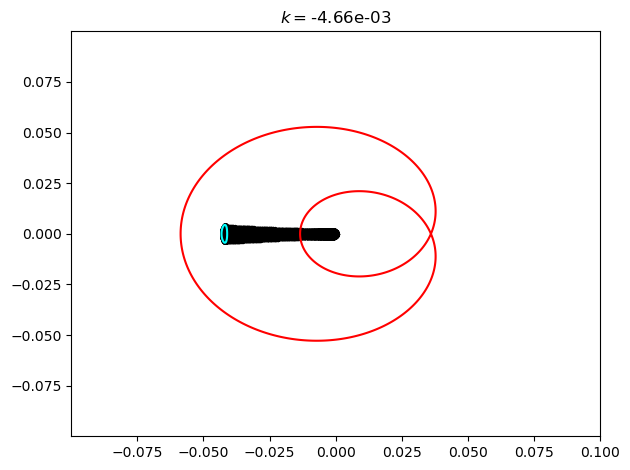

In [87]:
plt.clf()
T_PLOT = 0
ind_plot = npy.where(sol.t > T_PLOT)
e_vals = sol.y[1, :][ind_plot]
th_vals = (
    sol.y[3, :][ind_plot] + params[omp] * sol.t[ind_plot] - sol.y[2, :][ind_plot]
) % (2 * npy.pi)
plt.title(r"$k=$"+f"{k_vals[snap_index]:0.2e}")
plt.scatter(e_vals * npy.cos(th_vals), e_vals * npy.sin(th_vals), s=2, c="k")
plt.contour(
    e_grid * npy.cos(th_grid),
    e_grid * npy.sin(th_grid),
    H_func(th_grid, e_grid),
    levels=sorted([H_vals[snap_index],H_sep_val]),
    colors=["red","cyan"],
    #linestyles=["--","--"],
)
# plt.colorbar()
plt.tight_layout()
plt.show()

In [88]:
# e as a function of k and a
e_func = lambdify(e,e_expr_a_k.subs({ac:ac_vals[snap_index],j:params[j],k:k_vals[snap_index]}))
e_func

<function _lambdifygenerated(e)>

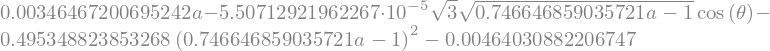

In [89]:
# H(a,th;k)
H_a_th = H_simp_expr_plugin.subs({e:e_expr_a_k}).subs({ac:ac_vals[snap_index],j:params[j],k:k_vals[snap_index]})
H_a_th_func = lambdify([th,a],H_a_th)
display(H_a_th)

In [90]:
a_grid, th_a_grid = npy.meshgrid(npy.linspace(1.33,1.36,1000),npy.linspace(0,2*npy.pi,1000))

<lambdifygenerated-45>:2: RuntimeWarning: invalid value encountered in sqrt
  return 0.00346467200695242*a - 5.50712921962267e-5*sqrt(3)*sqrt(0.746646859035721*a - 1)*cos(theta) - 0.495348823853268*(0.746646859035721*a - 1)**2 - 0.00464030882206747
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

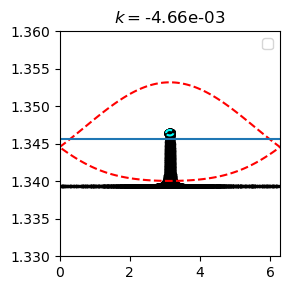

<Figure size 640x480 with 0 Axes>

In [91]:
T_PLOT = 3e5
plt.clf()
plt.figure(figsize=(3,3))
a_vals = (sol.y[0, :][ind_plot])**(-2./3)
th_vals = (
    sol.y[3, :][ind_plot] + params[omp] * sol.t[ind_plot] - sol.y[2, :][ind_plot]
) % (2 * npy.pi)
plt.scatter(th_vals,a_vals, s=2, c="k")
levels = [H_sep_val,H_vals[snap_index]]
#levels = npy.linspace(float(H_sep_val),H_vals[snap_index],10)
cs = plt.contour(
    th_a_grid,
    a_grid,
    H_a_th_func(th_a_grid, a_grid),
    levels=levels,
    colors=["red","cyan"],
    linestyles=["--","--"],
)
labels=[r"$H=H_{\rm sep}$"+f"{H_sep_val}",r"$H=$"+f"{H_vals[snap_index]}"]
plt.title(r"$k=$"+f"{k_vals[snap_index]:0.2e}")
plt.axhline(y=ac_vals[snap_index])
# plt.colorbar()
plt.legend()
plt.tight_layout()
plt.show()
save_to_clipboard()

# Single run hand placed

In [92]:
params = {}
params = {
    j: 2,
    mup: 5e-5,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    b1_3_2: 12.08476062046314,
    b2_3_2: 10.485706741948807,
    ep: 0.0
}

alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
params[omp] = 0
params[om] = params[omp] * alpha0val**3.5

In [93]:

ap_sel =1.026880764932741 #ap_vals[-1]
print(ap_sel)
ac_sel = 1.34559446378806 #ac_vals[-1]
print(ac_sel)
k_sel = -0.004662043471396658#k_vals[-1]
print(k_sel)
np_sel =0.9609924410332833 #np_vals[-1]
print(np_sel)
pomp_sel = 0 #params[omp]*sol.t[-1]
print(pomp_sel)

1.026880764932741
1.34559446378806
-0.004662043471396658
0.9609924410332833
0


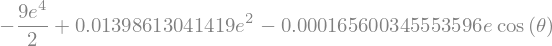

In [94]:
H_e_th_sel = H_simp_expr.subs({
    j: params[j],
    om: params[om],
    mup: params[mup],
    ap: ap_sel,
    k: k_sel,
    b: params[b],
    ac: ac_sel,
})
H_e_th_sel_func = lambdify([th,e],H_e_th_sel)
H_e_th_sel


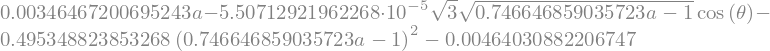

In [95]:
H_a_th_sel = H_simp_expr.subs({e:e_expr_a_k}).subs({
    j: params[j],
    om: params[om],
    mup: params[mup],
    ap: ap_sel,
    k: k_sel,
    b: params[b],
    ac: ac_sel,
})
H_a_th_sel_func = lambdify([th,a],H_a_th_sel)
H_a_th_sel

In [96]:

thdot_sel = H_e_th_sel.diff(e)/(2*e)
thdot_sel


KeyboardInterrupt: 

In [ ]:

root0 = brentq((lambda x: lambdify([th,e],thdot_sel*e)(npy.pi,x)), 0.001,0.1)
root1 = brentq((lambda x: lambdify([th,e],thdot_sel*e)(0,x)), 0.005,0.02)
root2 = brentq((lambda x: lambdify([th,e],thdot_sel*e)(0,x)), 0.02,0.1)

In [ ]:
print(root0)
print(root1)
print(root2)

0.04210147957764366
0.006063626875062423
0.036037852702773085


In [ ]:
# Value of H for separatrix at this k
H_sep_val = H_e_th_sel.subs({th:0,e:root2})
display(H_sep_val)

In [ ]:
H_val_sel = 5e-6
th_sel = npy.pi+1

In [ ]:
H_val_sel

In [ ]:
e_grid, th_grid = npy.meshgrid(npy.linspace(0.001,0.1,1000), npy.pi+npy.linspace(-npy.pi,npy.pi,1000))

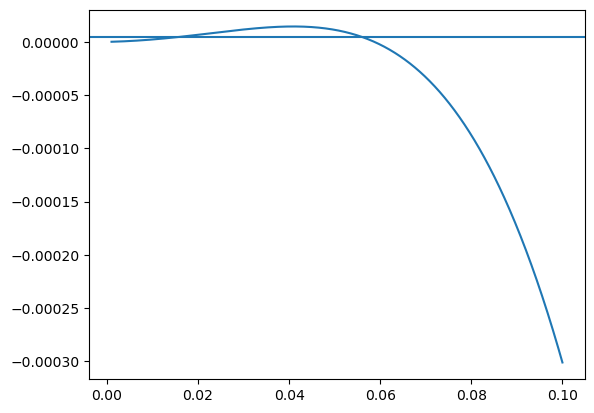

In [ ]:
plt.clf()
#plt.plot(-e_grid[0,:],H_e_th_sel_func(npy.pi,e_grid[0,:]))
#plt.plot(e_grid[0,:],H_e_th_sel_func(0,e_grid[0,:]))
plt.plot(e_grid[0,:],H_e_th_sel_func(th_sel,e_grid[0,:]))
plt.axhline(y=H_val_sel)
plt.show()

In [ ]:
_ = lambda x: H_e_th_sel_func(th_sel,x)-H_val_sel
e0_sel = brentq(_,0.045,0.06)
e0_sel

In [ ]:
a0_sel =solve(Eq(k_sel,k_expr.subs({e:e0_sel,ac:ac_sel,j:params[j]})), a)[0]
a0_sel

In [ ]:
pom0_sel = 1

In [ ]:
convs = {ap: n ** Rational(2, 3) / np ** Rational(2, 3) * a, th: thp + omp * t - pom}
xp = [n, e, pom, thp, np, t]
T_TURNOFF = 0
funs = [
    iterfun.subs(convs).subs(params)
    for iterfun in [ndot, edot + edsec, pomdot + pomdsec, thpdot]
]
funs
funcl = lambdify(xp, funs)
def func(t, x0):
    return funcl(*x0, np_sel, t)
teval = npy.linspace(0, 2 * npy.pi * 1e4, 10000)
sol = sp.integrate.solve_ivp(
    func,
    [teval[0], teval[-1]],
    [a0_sel**(-3./2), e0_sel, pom0_sel, th_sel-pom0_sel+pomp_sel],
    t_eval=teval,
    rtol=1e-9,
    #atol=1e-9,
    method="DOP853",
)

In [ ]:
a_vals = sol.y[0, :] ** (-2.0 / 3)

ap_vals = np_sel ** (-2.0 / 3)
nc_vals = (params[om] + params[j] * np_sel) / (params[j] + 1)
ac_vals = nc_vals ** (-2.0 / 3)
e_vals = sol.y[1, :]
th_vals = (sol.y[3, :] + params[omp] * sol.t - sol.y[2, :]) % (2 * npy.pi)
k_vals = (a_vals - ac_vals) / ac_vals - (params[j] + 1) * e_vals**2
k_crit = -(
    (3 * (params[j] + 1) * ap_vals * params[b] ** 2 / (params[j] ** 2 * ac_vals))
    ** (1.0 / 3)
) * params[mup] ** (2.0 / 3)

H_vals = (
    -0.75 * (params[j] + 1) * (params[j] + params[om] / np_sel) * e_vals**4
    - 1.5 * k_vals * (params[j] + params[om] / np_sel) * e_vals**2
    - 2
    * params[b]
    * npy.sqrt(ap_vals / ac_vals)
    * params[mup]
    * e_vals
    * npy.cos(th_vals)
)

In [ ]:
#plt.clf()
#plt.plot(sol.t,H_vals)
#plt.show()

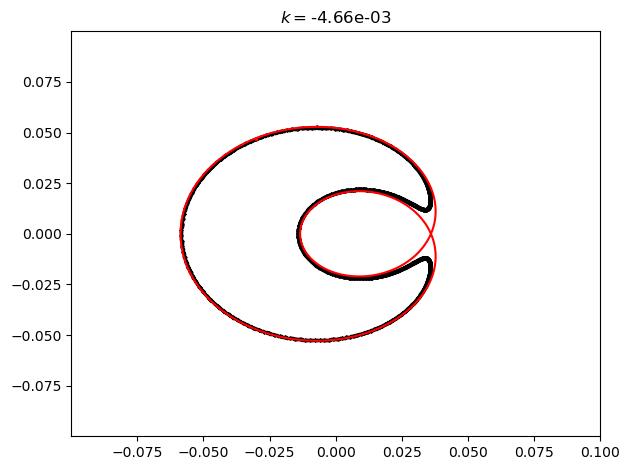

In [ ]:
plt.clf()
e_vals = sol.y[1, :]
th_vals = (
    sol.y[3, :] + params[omp] * sol.t - sol.y[2, :]
) % (2 * npy.pi)
plt.title(r"$k=$"+f"{k_sel:0.2e}")
plt.scatter(e_vals * npy.cos(th_vals), e_vals * npy.sin(th_vals), s=2, c="k")
plt.scatter(e_vals[0] * npy.cos(th_vals[0]), e_vals[0] * npy.sin(th_vals[0]), s=2, c="r")
plt.contour(
    e_grid * npy.cos(th_grid),
    e_grid * npy.sin(th_grid),
    H_e_th_sel_func(th_grid, e_grid),
    levels=sorted([H_sep_val]),
    colors=["red","cyan"],
    #linestyles=["--","--"],
)
# plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
a_grid, th_a_grid = npy.meshgrid(npy.linspace(1.33,1.36,1000),npy.linspace(0,2*npy.pi,1000))

<lambdifygenerated-39>:2: RuntimeWarning: invalid value encountered in sqrt
  return 0.00346467200695243*a - 5.50712921962268e-5*sqrt(3)*sqrt(0.746646859035723*a - 1)*cos(theta) - 0.495348823853268*(0.746646859035723*a - 1)**2 - 0.00464030882206747
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

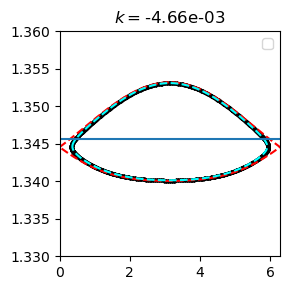

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.clf()
plt.figure(figsize=(3,3))
a_vals = (sol.y[0, :])**(-2./3)
th_vals = (
    sol.y[3, :] + params[omp] * sol.t - sol.y[2, :]
) % (2 * npy.pi)
plt.scatter(th_vals,a_vals, s=2, c="k")
levels = [H_sep_val,H_val_sel]
#levels = npy.linspace(float(H_sep_val),H_vals[snap_index],10)
cs = plt.contour(
    th_a_grid,
    a_grid,
    H_a_th_sel_func(th_a_grid, a_grid),
    levels=levels,
    colors=["red","cyan"],
    linestyles=["--","--"],
)
labels=[r"$H=H_{\rm sep}$"+f"{H_sep_val}",r"$H=$"+f"{H_val_sel}"]
plt.title(r"$k=$"+f"{k_sel:0.2e}")
plt.axhline(y=ac_sel)
# plt.colorbar()
plt.legend()
plt.tight_layout()
plt.show()
save_to_clipboard()

# Separatrix at k_crit for $\theta$ vs $\theta_p$ with $\omega$, $\omega_p$

In [ ]:
params = {}
params = {
    j: 2,
    mup: 5e-5,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    b1_3_2: 12.08476062046314,
    b2_3_2: 10.485706741948807,
    ep: 0.0
}
alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
params[omp] = 0.0
params[om] = 0#params[omp] * alpha0val**3.5

In [ ]:
np_sel = 1
ap_sel = np_sel**(-2./3)
nc_sel = (params[j]*np_sel + params[om])/(params[j]+1)
ac_sel = nc_sel**(-2./3)
pomp_sel = 0
print(np_sel)
print(ap_sel)
print(nc_sel)
print(ac_sel)

1
1.0
0.6666666666666666
1.3103706971044484


In [ ]:
k_sel = -(
    (3 * (params[j] + 1) * ap_sel * params[b] ** 2 / (params[j] ** 2 * ac_sel))
    ** (1.0 / 3)
) * params[mup] ** (2.0 / 3)
k_sel

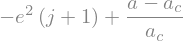

In [ ]:
k_expr

In [ ]:
k_sel = 1.*k_sel
k_sel

In [ ]:
#k_sel = -1

- okay why do these have different numerical values?? 
- its negative & i put in -ap_sel bc its under a cubed root
  - had ap_sel in denom of cubed root instead of ac_sel

In [ ]:
-solve(discriminant(term_multiply(H_simp_expr.subs({om:0}).diff(e),e)),k)[0].subs({j:params[j],th:0,b:params[b],mup:params[mup],ap:-ap_sel,ac:ac_sel}).evalf()

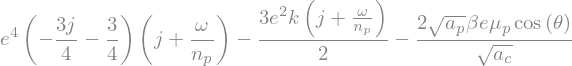

In [ ]:
H_simp_expr

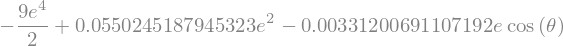

In [ ]:
H_e_th_sel = H_simp_expr.subs({
    j: params[j],
    om: params[om],
    mup: params[mup],
    ap: ap_sel,
    k: k_sel,
    b: params[b],
    ac: ac_sel,
    np:np_sel
})
H_e_th_sel_func = lambdify([th,e],H_e_th_sel)
H_e_th_sel

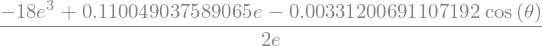

In [ ]:
thdot_sel = H_e_th_sel.diff(e)/(2*e)
thdot_sel

In [ ]:
#plt.clf()
#e_dom = npy.linspace(0.,0.1,1000)
#_ = lambda x: lambdify([th,e],thdot_sel*e)(0,x)
#plt.plot(e_dom, [_(x) for x in e_dom])
#plt.axhline(y=0,c="k")
#plt.show()

In [ ]:
#e_search = npy.linspace(0.0,1,10000)
#_ = lambda x: -lambdify([th,e],thdot_sel*e)(0,x)
#roots = []
#for i in range(len(e_search)-1):
#    #root = minimize(_,0.05,bounds=[(0,.1)]).x[0]
#    try:
#        root = brentq(_,e_search[i],e_search[i+1])
#        roots += [root]
#    except ValueError:
#        pass
#root = max(roots)

In [ ]:
_ = lambda x: -lambdify([th, e], thdot_sel*e)(0,x)
root = minimize(_,0.05,bounds=[(0,.1)]).x[0]
root

In [ ]:
H_sep_val_sel = H_e_th_sel.subs({e:root,k:k_sel,th:0})
H_sep_val_sel

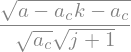

In [ ]:
e_expr_a_k

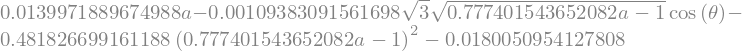

In [ ]:
H_a_th_sel = H_simp_expr.subs({e:e_expr_a_k}).subs({
    j: params[j],
    om: params[om],
    mup: params[mup],
    ap: ap_sel,
    k: k_sel,
    b: params[b],
    ac: ac_sel,
    np:np_sel
})
H_a_th_sel_func = lambdify([th,a],H_a_th_sel)
H_a_th_sel

- The separatrix value is correct in e-th space.

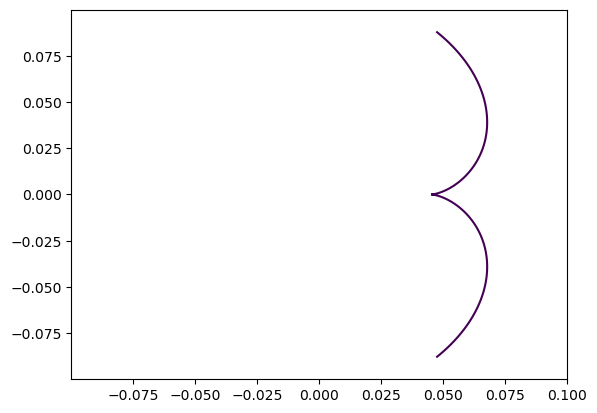

In [ ]:
th_dom, e_dom = npy.meshgrid(npy.linspace(0,2*npy.pi,1000),npy.linspace(0,0.1,1000))
plt.clf()
cs = plt.contour(npy.cos(th_dom)*e_dom,npy.sin(th_dom)*e_dom,H_e_th_sel_func(th_dom,e_dom),levels=[H_sep_val_sel]) #,levels=(1+npy.linspace(2,-10,10))*H_sep_val_sel)
#plt.clabel(cs, inline=True, fmt="%0.3e")
plt.show()

- it's just a line in a-th space
- Why are there no contours under?

<lambdifygenerated-39>:2: RuntimeWarning: invalid value encountered in sqrt
  return 0.0139971889674988*a - 0.00109383091561698*sqrt(3)*sqrt(0.777401543652082*a - 1)*cos(theta) - 0.481826699161188*(0.777401543652082*a - 1)**2 - 0.0180050954127808


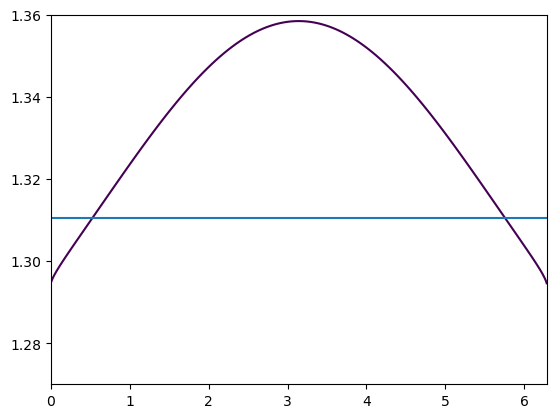

In [ ]:
th_dom, a_dom = npy.meshgrid(npy.linspace(0,2*npy.pi,1000),npy.linspace(1.27,1.36,1000))
plt.clf()
#cs = plt.contour(th_dom,a_dom,H_a_th_sel_func(th_dom,a_dom),levels=sorted([H_sep_val_sel]+[x for x in npy.linspace(-4e-5,4e-5,50)])) #,levels=(1+npy.linspace(2,-10,10))*H_sep_val_sel)
cs = plt.contour(th_dom,a_dom,H_a_th_sel_func(th_dom,a_dom),levels=[H_sep_val_sel])
#plt.clabel(cs, inline=True, fmt="%0.3e")
#cs = plt.pcolormesh(th_dom,a_dom,H_a_th_sel_func(th_dom,a_dom))
plt.axhline(y=ac_sel)
plt.show()

# Params

In [621]:
convs = {}
convs = {ap: n ** Rational(2, 3) / np ** Rational(2, 3) * a, th: thp + omp * t - pom}
params = {}
params = {
    j: 2,
    mup: 5e-5,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    b1_3_2: 0,#12.08476062046314,
    b2_3_2: 0,#10.485706741948807,
    ep: 0.03,
}
alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
params[omp] = 1e-5
params[om] = params[omp] * alpha0val**3.5
print(params[omp]-params[om])
k_sel = -0.003
N_runs = 20
a0vals, th0vals = npy.random.uniform(1.29, 1.33, N_runs), npy.random.uniform(0, 2 * npy.pi, N_runs)
pom0val = npy.pi

6.1174201567275606e-06


# $\theta_p$ separatrix

In [622]:
thp_dot = symbols(r"\dot{\theta_p}")
thp_dot

In [623]:
thp_dot_expr = (j+1)*n-j*np - omp
thp_dot_expr

In [624]:
ncp = symbols(r"n_{c\,p}")
ncp

In [625]:
nup = symbols(r"\nu_{p}")
nup

In [626]:
acp = symbols(r"a_{c\,p}")
acp

In [627]:
np_sel = 1
ncp_sel = np_sel*((params[j])/(params[j]+1) + params[omp]/np_sel/(params[j]+1))
print(ncp_sel)
ap_sel = np_sel**(-2./3)
print(ap_sel)
acp_sel = ncp_sel**(-2./3)
print(acp_sel)

0.66667
1.0
1.310366329220324


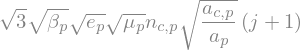

In [628]:
nup_expr = ncp*(3*bp/ap*acp)**Rational(1,2)*(j+1)*sqrt(mup*ep)
nup_expr

In [629]:
H_p_simp_expr = Rational(1,2)*thp_dot**2 + nup**2*cos(thp)

- $\dot\theta_p$ is the canonical conjugate momentum to $\theta_p$

In [630]:
H_p_simp_expr.diff(thp_dot)

In [631]:
H_p_simp_expr.diff(thp)

- fixed points at $\theta_p=0,2\pi$, $\dot\theta_p=0$

In [632]:
params[ep]

In [633]:
H_p_sep_val_sel = H_p_simp_expr.subs({thp_dot:0,thp:0}).subs({nup:nup_expr}).subs({
    j:params[j],
    bp:params[bp],
    acp:acp_sel,
    ep:params[ep],
    mup:params[mup],
    ncp:ncp_sel,
    ap:ap_sel,
})
H_p_sep_val_sel 

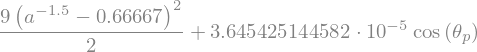

In [634]:
H_p_a_th_sel = H_p_simp_expr.subs({nup:nup_expr}).subs({thp_dot:thp_dot_expr}).subs({
    j:params[j],
    bp:params[bp],
    acp:acp_sel,
    ep:params[ep],
    mup:params[mup],
    ncp:ncp_sel,
    ap:ap_sel,
    np:np_sel,
    omp:params[omp],
    n:a**(-3/2)
})
H_p_a_th_sel_func = lambdify([thp,a],H_p_a_th_sel)
H_p_a_th_sel

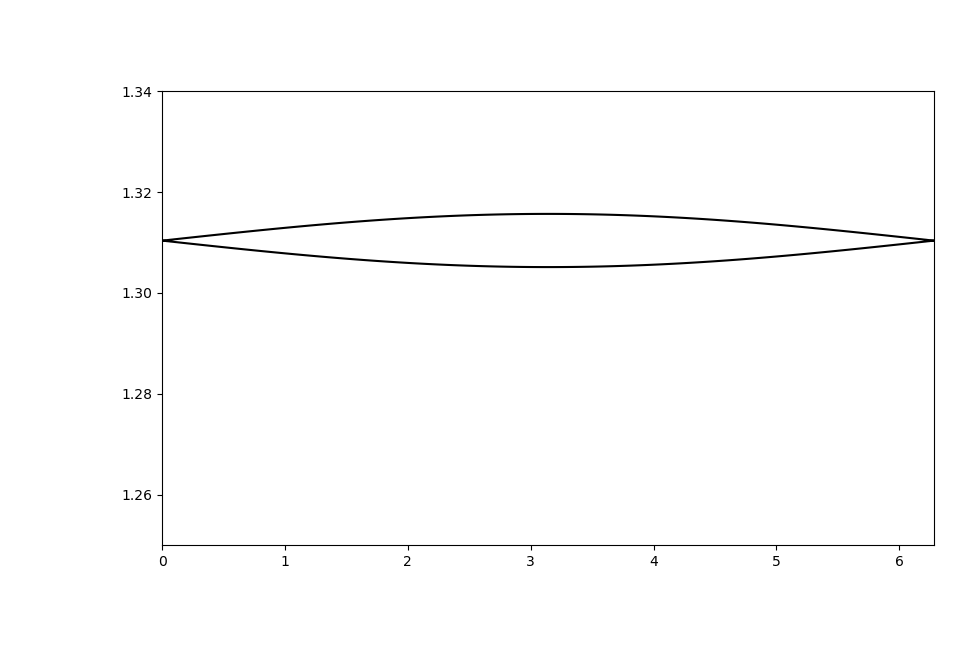

In [635]:
thp_dom, a_dom = npy.meshgrid(npy.linspace(0,2*npy.pi,1000),npy.linspace(1.25,1.34,1000))
plt.clf()
cs = plt.contour(thp_dom,a_dom,H_p_a_th_sel_func(thp_dom,a_dom),levels=[H_p_sep_val_sel],colors="k")
#cs = plt.contour(th_dom,a_dom,H_a_th_sel_func(th_dom,a_dom),levels=[H_sep_val_sel],colors="r")
#plt.clabel(cs, inline=True, fmt="%0.3e")
#cs = plt.pcolormesh(th_dom,a_dom,H_p_a_th_sel_func(thp_dom,a_dom))
#plt.colorbar(cs)
plt.show()

Below is at ep=0.02. 

In [636]:
top = 1.316894
bottom = 1.3146949

In [637]:
f"{top**(-2./3) - bottom**(-2./3):0.2e}"

'-9.28e-04'

# Separatrix for a grid of initial values (as in FLI plots)

I think I realized in general I maybe should just do a constant k. It becomes a little cumbersome with constant a & e, because $k>k_{sep}$ in in places (and there is no separatrix) not to mention the fact that defining a separatrix kind of requires a constant $k$.

This should be a relatively straightforward thing to do, and then I can do the FLI plots and choose e as a function of k=const and a on param space.

In [638]:
#params = {}
#params = {
#    j: 2,
#    mup: 5e-5,
#    bp: 1.5455341716765871,
#    b: 1.8956507412695471,
#    b1_3_2: 12.08476062046314,
#    b2_3_2: 10.485706741948807,
#    ep: 0.0
#}
#alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
#params[omp] = 0.0
#params[om] = 0.01#params[omp] * alpha0val**3.5

In [639]:
np_sel = 1
ap_sel = np_sel**(-2./3)
nc_sel = (params[j]*np_sel + params[om])/(params[j]+1)
ac_sel = nc_sel**(-2./3)
pomp_sel = 0

In [640]:
_e_func_ak = lambdify([a,k],solve(Eq(k_expr,k),e)[1].subs({ac:ac_sel,j:params[j]}))
def e_func_ak(_a,_k):
    if _a-ac_sel*_k-ac_sel > 0:
        return _e_func_ak(_a,_k)
    else:
        return 0.000


In [641]:
#_ = npy.linspace(1.29,1.33,1000)
#plt.plot(_,[e_func_ak(x,k_sel) for x in _])

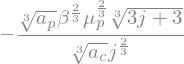

-0.00248932645989752


In [642]:
H_simp_expr_plugin = H_simp_expr.subs(params).subs({ac:ac_sel,ap:ap_sel,np:np_sel})
display(H_simp_expr_plugin)
poly_FP_expr = H_simp_expr_plugin.diff(e)
display(poly_FP_expr)
k_sep_expr = -(
    (3 * (j + 1) * ap * b ** 2 / (j ** 2 * ac))
    ** Rational(1,3)
) * mup ** Rational(2,3)
display(k_sep_expr)
k_sep_val = k_sep_expr.subs(params).subs({ac:ac_sel,ap:ap_sel}).evalf()
print(k_sep_val)

In [643]:
_a_expr_ek = solve(Eq(k_expr,k),a)[0]
a_func_ek = lambdify([e,k],_a_expr_ek.subs({j:params[j],ac:ac_sel}))
_a_expr_ek

In [644]:
#k_sel = -0.006
#k_sel = -0.00249

In [645]:
poly_FP_expr.subs(th,0)

In [646]:
_H_func_keth = lambdify([k, e, th], H_simp_expr_plugin)
H_func_akth = lambda _a, _k, _th: _H_func_keth(k_sel, e_func_ak(_a,_k),_th)
_poly_unstFP_func_ek =  lambdify([e,k],poly_FP_expr.subs({th:0}))

In [647]:
def H_sep_val_func(_k):
    e_search = npy.linspace(0,1,100000)
    roots = []
    _search = lambda _e: _poly_unstFP_func_ek(_e, _k)
    for i in range(len(e_search)-1):
        try:
            root = brentq(_search, e_search[i], e_search[i+1])
            roots += [root]
        except ValueError:
            pass
    return(_H_func_keth(_k,max(roots),0),max(roots))
H_sep_val_func(k_sel)

In [648]:
#th_dom, a_dom = npy.meshgrid(npy.linspace(0,2*npy.pi,1000), npy.linspace(1.3026,1.32,1000))
#th_dom, a_dom = npy.meshgrid(npy.linspace(0,2*npy.pi,1000), npy.linspace(1.3075,1.33,1000))
th_dom, a_dom = npy.meshgrid(npy.linspace(0,2*npy.pi,1000), npy.linspace(1.25,1.33,1000))
H_dom = npy.zeros(th_dom.shape)
for it in range(len(H_dom[:,0])):
    for jt in range(len(H_dom[0,:])):
        H_dom[it,jt] = H_func_akth(a_dom[it,jt],k_sel,th_dom[it,jt])

In [649]:
#plt.clf()
#H_sep_val, e_sep_val = H_sep_val_func(k_sel)
#plt.contour(th_dom,a_dom,H_dom,levels=[H_sep_val])
##plt.pcolormesh(th_dom,a_dom,H_dom)
#plt.contour(th_dom,a_dom,H_p_a_th_sel_func(thp_dom,a_dom),levels=[H_p_sep_val_sel],colors="k")
#plt.plot([0,2*npy.pi],[a_func_ek(e_sep_val,k_sel),a_func_ek(e_sep_val,k_sel)])
#plt.show()

# Poincaire Sections

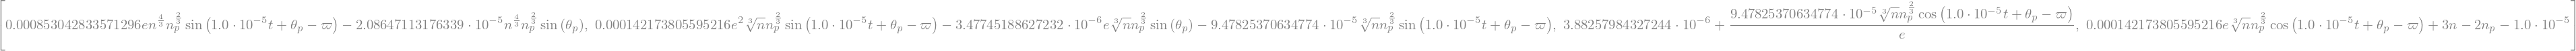

In [650]:
#params = {}
#params = {
#    j: 2,
#    mup: 5e-5,
#    bp: 1.5455341716765871,
#    b: 1.8956507412695471,
#    b1_3_2: 0,#12.08476062046314,
#    b2_3_2: 0,#10.485706741948807,
#    ep: 0.0
#}
#
#alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
#params[omp] = 0
#params[om] = params[omp] * alpha0val**3.5
#
#
funs = [
    iterfun.subs(convs).subs(params)
    for iterfun in [ndot, edot + edsec, pomdot + pomdsec, thpdot]
]
funs

In [651]:
xp = [n, e, pom, thp, np, t]

In [652]:
funcl = lambdify(xp, funs)


def func(t, x0):
    npval = 1
    return funcl(*x0, npval, t)


def section(t, x0):
    return(npy.cos(x0[2]))
    #return(npy.cos(x0[3]))
    # return npy.cos(x0[3] + params[omp] * t)


def get_section(a0val, kval, th0val, pom0val):
    nc_sel = (params[j] * 1 + params[om]) / (params[j] + 1)
    ac_sel = nc_sel ** (-2.0 / 3)
    e_sel = npy.sqrt(a0val - ac_sel * kval - ac_sel) / npy.sqrt(
        ac_sel * (params[j] + 1)
    )
    teval = npy.linspace(0, 2 * npy.pi * 0.5e5, 10000)
    thp0val = th0val + pom0val
    sol = sp.integrate.solve_ivp(
        func,
        [teval[0], teval[-1]],
        [a0val ** (-3.0 / 2), e_sel, pom0val, thp0val],
        t_eval=teval,
        rtol=1e-9,
        # atol=1e-9,
        method="DOP853",
        events=section,
    )

    events_th0 = (sol.y_events[0][:, 3] + params[omp] * sol.t_events[0]) % (2 * npy.pi)
    events_thp = sol.y_events[0][:, 3] % (2 * npy.pi)
    events_th = (
        sol.y_events[0][:, 3] + params[omp] * sol.t_events[0] - sol.y_events[0][:, 2]
    )
    events_th = events_th % (2 * npy.pi)
    events_e = sol.y_events[0][:, 1]
    events_n = sol.y_events[0][:, 0]
    events_a = events_n ** (-2.0 / 3)
    return [events_a, events_th, events_thp, events_th0, events_e]

In [653]:
runs = {}
for i in range(N_runs):
    a0val = a0vals[i]
    th0val = th0vals[i]
    print(i)
    try:
        runs[(a0val, k_sel)] = get_section(a0val, k_sel, th0val, pom0val)
    except ValueError:
        pass

0
1
2


/var/folders/rv/30_ngz5x5l5djjdvflk_6wwm0000gn/T/ipykernel_49953/3258571337.py:18: RuntimeWarning: invalid value encountered in sqrt
  e_sel = npy.sqrt(a0val - ac_sel * kval - ac_sel) / npy.sqrt(


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# Plot

10


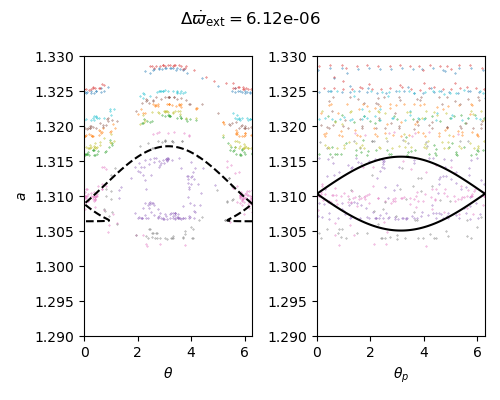

In [654]:
%matplotlib widget 
#%matplotlib inline
plt.clf()
plt.figure(figsize=(5,4))
print(len(runs))
H_sep_val, _ = H_sep_val_func(k_sel)
for a0val, kval in runs.keys():
    plt.subplot(1,2,1)
    plt.scatter(runs[(a0val,kval)][1],runs[(a0val,kval)][0],s=0.1)
    plt.subplot(1,2,2)
    plt.scatter((runs[(a0val,kval)][2]+npy.pi)%(2*npy.pi),runs[(a0val,kval)][0],s=0.1)
    #plt.scatter(runs[(a0val,kval)][4]*npy.cos(runs[(a0val,kval)][1]),runs[(a0val,kval)][4]*npy.sin(runs[(a0val,kval)][1]),s=1)
plt.subplot(1,2,1)
plt.ylim(1.29,1.33)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$a$")
plt.contour(th_dom,a_dom,H_dom,levels=[H_sep_val],colors="k")
plt.subplot(1,2,2)
plt.ylim(1.29,1.33)
plt.xlabel(r"$\theta_p$")
plt.contour(th_dom,a_dom,H_p_a_th_sel_func(thp_dom,a_dom),levels=[H_p_sep_val_sel],colors="k")
#plt.plot([0,2*npy.pi],[a_func_ek(0,k_sel),a_func_ek(0,k_sel)],c="k",ls="--")
plt.suptitle(r"$\Delta\dot\varpi_{\rm ext}=$"+f"{params[omp]-params[om]:0.2e}")
#plt.suptitle(r"$\omega_p=$"+f"{params[omp]:0.2e}\n"+r"$\omega=$"+f"{params[om]:0.2e}")
plt.tight_layout()